# PCA of Constant Maturity Treasury Rates

## Data Download

In [48]:
import pandas as pd

# Maturities list
maturities = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS10', 'DGS20', 'DGS30']

rates_df = pd.DataFrame()

for maturity in maturities:

    file_name = f"{maturity}.csv"

    temp_df = pd.read_csv(file_name, parse_dates=['DATE'], index_col='DATE')

    temp_df.rename(columns={maturity: maturity}, inplace=True)

    if rates_df.empty:
        rates_df = temp_df
    else:
        rates_df = pd.merge(rates_df, temp_df, left_index=True, right_index=True, how='outer')

rates_df = rates_df.fillna(method='ffill')

rates_df = rates_df['2001-01-01':'2007-12-31']

In [50]:
Rtj = rates_df.copy()

In [51]:
rates_df = rates_df.apply(pd.to_numeric, errors='coerce')

## Resample to Weekly, Train/Test Split, PCA modeling

Explained variance by component: [0.76888769 0.13446135 0.0554575  0.02128603 0.00837001 0.00484608
 0.00262643 0.00169246 0.00137848 0.00099396]


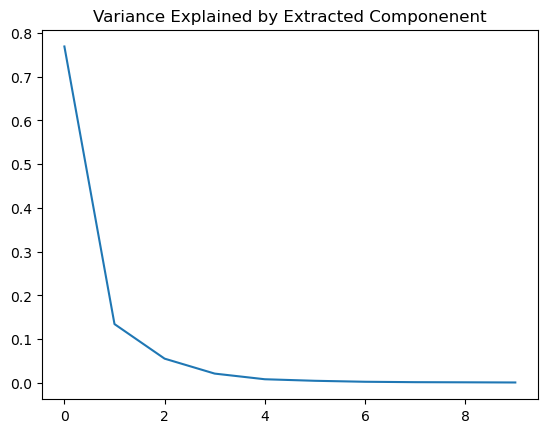

In [52]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

weekly_rates = rates_df.resample('W').last()

weekly_changes = weekly_rates.diff().dropna()

train = weekly_changes['2001-01-01':'2006-12-31']
test = weekly_changes['2007-01-01':'2008-12-31']

pca = PCA()
X = train.values

X_pca = pca.fit_transform(X)

print("Explained variance by component: %s" % pca.explained_variance_ratio_)

plt.plot(pca.explained_variance_ratio_)
plt.title('Variance Explained by Extracted Componenent')
plt.show()

## Plotting Principal Components

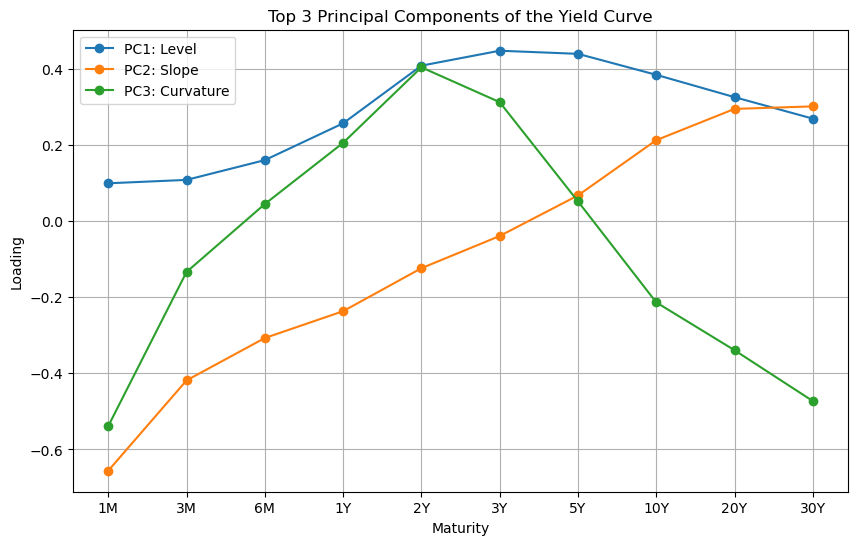

In [58]:
import matplotlib.pyplot as plt

maturities = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '10Y', '20Y', '30Y']

pc1, pc2, pc3 = pca.components_[:3]

plt.figure(figsize=(10, 6))

plt.plot(maturities, pc1, marker='o', label='PC1: Level')
plt.plot(maturities, pc2, marker='o', label='PC2: Slope')
plt.plot(maturities, pc3, marker='o', label='PC3: Curvature')

plt.xlabel('Maturity')
plt.ylabel('Loading')
plt.title('Top 3 Principal Components of the Yield Curve')
plt.legend()
plt.grid(True)

plt.show()


### Interpretations:

**First Principal Component (PC1):**
   - **Interpretation:** Often associated with the "Level" factor, which captures the overall level of interest rates.
   - **Behavior:** When PC1 increases or decreases, all maturities tend to move in the same direction.
   - **Physical Representation:** It typically represents a parallel shift across all maturities in the yield curve.

**Second Principal Component (PC2):**
   - **Interpretation:** Often linked with the "Slope" factor, which represents the tilt of the yield curve.
   - **Behavior:** PC2 usually captures variations between short-term and long-term rates.
   - **Physical Representation:** It typically represents a steepening or flattening of the yield curve without changing its overall level.

**Third Principal Component (PC3):**
   - **Interpretation:** Commonly associated with the "Curvature" factor, capturing the non-parallel shifts in the yield curve.
   - **Behavior:** It deals with the curvature in the middle maturities while holding the short and long maturities.
   - **Physical Representation:** It typically captures a humped or inverted U-shape movement in the yield curve.



## Build 3-factor model from PCA

In [59]:
X_pca_train_3 = X_pca[:, :3]

# Projecting data onto the first 3 principal components
train_3_factors = np.dot(X, pca.components_[:3, :].T)

# Captured variance by the first 3 components in training set
train_variance_captured = pca.explained_variance_ratio_[:3].sum() * 100

print(f'Training set: The first 3 components explain {train_variance_captured:.2f}% of the variance.')

Training set: The first 3 components explain 99.83% of the variance.


In [60]:
# Transforming test data using PCA components derived from training data
X_test = test.values
X_pca_test = pca.transform(X_test)

# Extract the first 3 principal components
X_pca_test_3 = X_pca_test[:, :3]

# Projecting test data onto the first 3 principal components
test_3_factors = np.dot(X_test, pca.components_[:3, :].T)

# It is critical to note that the variance explained in the test set will be the same as in the training set 
# because we're using the same PCA components to transform the test data.

print(f'Test set: The first 3 components explain {train_variance_captured:.2f}% of the variance.')

Test set: The first 3 components explain 99.83% of the variance.


Generally, PCA components derived from training data typically capture less variance in the test set due to overfitting or the presence of new variance not captured during training. However, the actual variance captured will depend on the specifics of the data. In this case, we do not have a dependent variable to predict given our factors. 